In [1]:
import sys; sys.path.append("..")
import utils

import copy
import random
import time

import numpy as np
np.set_printoptions(precision=3, suppress=True)

In [2]:
from matplotlib import pyplot as plt
import matplotlib; matplotlib.font_manager._rebuild()
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator
import seaborn as sns
from matplotlib import rc
sns.set_style('ticks')
font = {
    'font.family':'Roboto',
    'font.size': 12,
}
sns.set_style(font)
paper_rc = {
    'lines.linewidth': 3,
    'lines.markersize': 10,
}
sns.set_context("paper", font_scale=2, rc=paper_rc)
current_palette = sns.color_palette()

## Harness that runs a policy with the passed-in number of sub-clusters

In [3]:
def harness(policy, throughputs, scale_factors, priority_weights, cluster_spec, num_sub_clusters=1):
    start_time = time.time()
    sub_cluster_throughputs = []
    sub_cluster_scale_factors = []
    sub_cluster_priority_weights = []
    for i in range(num_sub_clusters):
        sub_cluster_throughputs.append({})
        sub_cluster_scale_factors.append({})
        sub_cluster_priority_weights.append({})
        for job_id in throughputs:
            if job_id % num_sub_clusters == i:
                sub_cluster_throughputs[-1][job_id] = copy.copy(throughputs[job_id])
                sub_cluster_scale_factors[-1][job_id] = scale_factors[job_id]
                sub_cluster_priority_weights[-1][job_id] = priority_weights[job_id]
    sub_cluster_cluster_spec = {worker_type: cluster_spec[worker_type] // num_sub_clusters
                                for worker_type in cluster_spec}
    full_allocation = {}
    for i in range(num_sub_clusters):
        sub_cluster_allocation = policy.get_allocation(sub_cluster_throughputs[i], sub_cluster_scale_factors[i],
                                                       sub_cluster_priority_weights[i], sub_cluster_cluster_spec)
        for job_id in sub_cluster_allocation:
            full_allocation[job_id] = sub_cluster_allocation[job_id]
    return full_allocation, time.time() - start_time

## Runtimes

In [4]:
def generate_throughputs(num_jobs,
                         cluster_spec,
                         oracle_throughputs,
                         seed):
    rng = random.Random()
    rng.seed(seed)
    throughputs = {}
    scale_factors = {}
    priority_weights = {}
    for job_id in range(num_jobs):
        job = utils.generate_job(throughputs=oracle_throughputs,
                                 rng=rng)
        job_type_key = (job.job_type, job.scale_factor)
        throughputs[job_id] = {}
        for worker_type in cluster_spec:
            throughputs[job_id][worker_type] = \
                oracle_throughputs[worker_type][job_type_key]['null']
        scale_factors[job_id] = 1
        priority_weights[job_id] = 1.0
    return throughputs, scale_factors, priority_weights

In [5]:
def get_runtimes(policy_name):
    oracle_throughputs = utils.read_all_throughputs_json_v2("../simulation_throughputs.json")
    data = {
        'policy': [],
        'num_jobs': [],
        'runtimes': []
    }    
    for num_jobs in [64, 128, 256, 512, 1024, 2048,
                     4096, 8192, 16384, 32768]:
        cluster_spec = {
            'v100': max(num_jobs // 4, 1),
            'p100': max(num_jobs // 4, 1),
            'k80': max(num_jobs // 4, 1),
        }
        for i in range(3):
            throughputs, scale_factors, priority_weights = \
                generate_throughputs(num_jobs, cluster_spec,
                                     oracle_throughputs, seed=i)
            policy = utils.get_policy(policy_name, solver='ECOS')
            _, vanilla_runtime = harness(policy, throughputs,
                                         scale_factors, priority_weights, cluster_spec)
            _, four_sub_clusters_runtime = harness(policy, throughputs,
                                                   scale_factors, priority_weights, cluster_spec,
                                                   num_sub_clusters=4)
            _, sixteen_sub_clusters_runtime = harness(policy, throughputs,
                                                      scale_factors, priority_weights, cluster_spec,
                                                      num_sub_clusters=16)
            for (policy_label, runtime) in zip(['Vanilla', '4 sub-clusters', '16 sub-clusters'],
                                               [vanilla_runtime, four_sub_clusters_runtime,
                                                sixteen_sub_clusters_runtime]):
                data['policy'].append(policy_label)
                data['num_jobs'].append(num_jobs)
                data['runtimes'].append(runtime)
    return data

In [6]:
def plot_runtimes(data):
    plt.figure(figsize=(6.5, 3))
    ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)
    sns.lineplot(x='num_jobs', y='runtimes', style='policy',
                 hue='policy',
                 data=data, ci=None,
                 markers=True)
    ax.set_xlabel("Number of jobs")
    ax.set_ylabel("Seconds")
    ax.set_xscale('log', basex=2)
    ax.set_yscale('log', basey=2)
    ax.set_xticks([64, 512, 4096, 32768])
    ax.set_xticklabels([64, 512, 4096, 32768])
    ax.set_xlim([64, 32768])
    ax.set_yticks([2**-8, 2**7])
    ax.set_yticks([2**-8, 2**-5, 2**-2, 2**1, 2**4, 2**7])
    ax.set_yticklabels([0.004, 0.031, 0.25, 2, 16, 128])
    sns.despine()

    leg = plt.legend(loc='upper left', frameon=False)

/lfs/1/keshav2/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  # Remove the CWD from sys.path while we load stuff.
/lfs/1/keshav2/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  # This is added back by InteractiveShellApp.init_path()


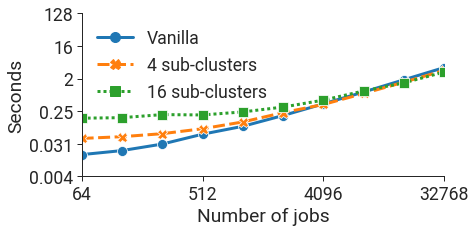

In [7]:
plot_runtimes(get_runtimes('max_min_fairness_perf'))

## Effective throughput ratios

In [8]:
def get_effective_throughput_ratios(policy_name, num_jobs):
    oracle_throughputs = utils.read_all_throughputs_json_v2("../simulation_throughputs.json")
    cluster_spec = {
        'v100': max(num_jobs // 4, 1),
        'p100': max(num_jobs // 4, 1),
        'k80': max(num_jobs // 4, 1),
    }
    for i in range(1):
        throughputs, scale_factors, priority_weights = \
            generate_throughputs(num_jobs, cluster_spec,
                                 oracle_throughputs, seed=i)
        policy = utils.get_policy(policy_name, solver='ECOS')
        vanilla_allocation, _ = harness(policy, throughputs,
                                        scale_factors, priority_weights, cluster_spec)
        four_sub_clusters_allocation, _ = harness(policy, throughputs,
                                                  scale_factors, priority_weights, cluster_spec,
                                                  num_sub_clusters=4)
        sixteen_sub_clusters_allocation, _ = harness(policy, throughputs,
                                                     scale_factors, priority_weights, cluster_spec,
                                                     num_sub_clusters=16)
        all_effective_throughputs = []
        for allocation in [vanilla_allocation, four_sub_clusters_allocation,
                           sixteen_sub_clusters_allocation]:
            effective_throughputs = {}
            for job_id in allocation:
                effective_throughput = 0.0
                for worker_type in allocation[job_id]:
                    effective_throughput += (allocation[job_id][worker_type] *
                                             throughputs[job_id][worker_type])
                effective_throughputs[job_id] = effective_throughput
            all_effective_throughputs.append(effective_throughputs)
    return all_effective_throughputs

In [9]:
def plot_effective_throughput_ratios(all_effective_throughputs):
    plt.figure(figsize=(6.5, 3))
    ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)
    for (effective_throughputs, label) in zip(
        all_effective_throughputs[1:], ['4 sub-clusters', '16 sub-clusters']):
        ax.plot(range(len(effective_throughputs)),
                [effective_throughputs[i] / all_effective_throughputs[0][i]
                 for i in range(len(effective_throughputs))], label=label)
    ax.set_xlabel("Job ID")
    ax.set_ylabel("Effective\nthroughput ratio")
    ax.set_xlim([0, len(effective_throughputs)])
    ax.set_ylim([0, 2.0])
    plt.legend(frameon=False)
    sns.despine()

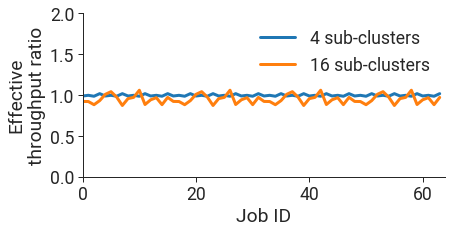

In [10]:
plot_effective_throughput_ratios(get_effective_throughput_ratios('max_min_fairness_perf', 64))